In [1]:
# !pip install -Uq --user nbdev
# !pip install huggingface_hub -U
!pip install -Uq --user 'timm==0.6.2.dev0'
try: import timm
except ModuleNotFoundError:
    !pip install -Uq 'timm==0.6.2.dev0'
try: import kaggle
except ModuleNotFoundError:
    !pip install -Uq --user 'kaggle'
from fastai.vision.all import *

In [2]:
timm.__version__

'0.6.2.dev0'

In [3]:
# easier to read
Path.BASE_PATh = path = Path('/notebooks/paddy/data')
train_images = path / 'train_images'
test_images = path / 'test_images'
test_images_files = get_image_files(test_images).sorted()
    

In [4]:
path.ls()

(#5) [Path('/notebooks/paddy/data/sample_submission.csv'),Path('/notebooks/paddy/data/test_images'),Path('/notebooks/paddy/data/train_images'),Path('/notebooks/paddy/data/train.csv'),Path('/notebooks/paddy/data/paddy-disease-classification.zip')]

In [5]:
try: df = pd.read_csv(path/'train.csv')
except FileNotFoundError:
    !paddy/get_data.sh
    df = pd.read_csv(path/'train.csv')
    

## Train using Grad accumulation

### Convnext

In [6]:
# WT 10 - 46 min- using Jeremy code for grad accumulation

tta_res = dict()
def train(desc, arch, item, batch, accum=False):
    kwargs = {'bs':32} if accum else {'bs': 64}
    # run a different subset everytime
    # we compared arch in prior nb, now we need best model
    # now diff arch, diff resize meth
    dls = ImageDataLoaders.from_folder(train_images, valid_pct=.2, 
                                       item_tfms=item, batch_tfms=batch,
                                       **kwargs)
    # only zero the gradient every 2 iters
    # matematiclly is the same
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(12, .01)
    tta_res[desc]= learn.tta(dl=dls.test_dl(test_images_files))
    save_pickle('tta_res.pkl', tta_res)
    learn.export(f"{arch}_{desc}")

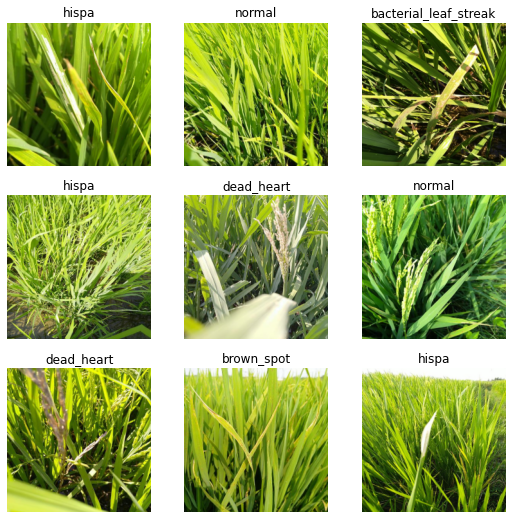

In [29]:
# tta_res quick review of the dls image transformers
dls = ImageDataLoaders.from_folder(train_images, seed=42, valid_pct=.2, 
                                            item_tfms=Resize(480, method='squish'), 
                                            batch_tfms=aug_transforms(size=224, min_scale=.75))
dls.train.show_batch()                   

For convnext normally you will want batch sizes of 32, conv final patch size is a 32 x 32 pixel. WT10 40min

- tiny vs small experiment

In [37]:
timm.list_models(filter='convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [38]:
arch = 'convnext_small'
train('convnext_small_squish', arch, item=Resize(480, method='squish'),
      batch=aug_transforms(size=224, min_scale=.75),
      accum=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.294601,0.962579,0.263335,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.604836,0.354730,0.109082,01:02
1,0.471682,0.323469,0.104757,01:02
2,0.427299,0.278301,0.081211,01:02
3,0.327149,0.222840,0.061028,01:02
4,0.246208,0.251281,0.062470,01:02
5,0.201716,0.250351,0.064392,01:02
6,0.115583,0.168991,0.036040,01:03
7,0.134693,0.149064,0.033157,01:02
8,0.069603,0.150252,0.030274,01:02
9,0.059206,0.125297,0.028352,01:03


In [39]:
arch = 'convnext_small'
train('convnext_small_crop', arch, item=Resize(480, method='crop'),
      batch=aug_transforms(size=224, min_scale=.75),
      accum=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.382154,0.885844,0.257088,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.635448,0.403424,0.123498,01:02
1,0.494289,0.327648,0.098030,01:02
2,0.495055,0.315931,0.103316,01:01
3,0.323782,0.278871,0.082653,01:01
4,0.311300,0.238314,0.062470,01:01
5,0.225122,0.212235,0.060548,01:02
6,0.180527,0.172829,0.040365,01:02
7,0.113214,0.154723,0.038924,01:02
8,0.078553,0.146973,0.036040,01:02
9,0.075015,0.126882,0.032196,01:01


### Vit small

In [40]:
timm.list_models(filter='vit*')

['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch

In [53]:
arch = 'vit_small_patch16_224'
train('vit_small_pad', arch, item=Resize((640,480), method='pad', pad_mode='zeros'), 
      batch=aug_transforms(size=224, min_scale=.75),
      accum=True
     )

epoch,train_loss,valid_loss,error_rate,time
0,1.290249,0.765894,0.236905,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.559794,0.387696,0.132629,00:36
1,0.518244,0.483493,0.152331,00:34
2,0.452326,0.331362,0.103316,00:34
3,0.407164,0.272629,0.082172,00:34
4,0.332717,0.254808,0.071120,00:34
5,0.267705,0.182841,0.055742,00:34
6,0.163131,0.185002,0.052859,00:34
7,0.139096,0.166086,0.043729,00:34
8,0.100215,0.164526,0.043248,00:33
9,0.085093,0.122236,0.027871,00:34


In [54]:
arch = 'vit_small_patch16_224'
train('vit_small_squish', arch, item=Resize((640,480), method='squish'), 
      batch=aug_transforms(size=224, min_scale=.75),
      accum=True
     )

epoch,train_loss,valid_loss,error_rate,time
0,1.321839,0.779430,0.251802,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.610570,0.341786,0.120615,00:35
1,0.453514,0.350935,0.122057,00:34
2,0.484041,0.495125,0.150889,00:35
3,0.395803,0.258787,0.097069,00:35
4,0.305676,0.189709,0.057665,00:34
5,0.252078,0.191548,0.053340,00:35
6,0.193895,0.121278,0.038924,00:35
7,0.119740,0.097050,0.031235,00:35
8,0.106860,0.080434,0.024027,00:35
9,0.067682,0.079848,0.022585,00:34


## Ensemble  

In [56]:
tta_res = load_pickle('tta_res.pkl')

In [74]:
tta_res_list = first(zip(*tta_res.values()))
tta_res_list += tta_res_list[-2:]  # add 2 vits twice at the end best models 2/3 vit vs 1/3 convnext

In [75]:
t_tta = torch.stack(tta_res_list)

In [78]:
avg_pr = t_tta.mean(0)
idxs = avg_pr.argmax(dim=1)
# idx.shape
# then submit as before  

In [79]:
t_tta.shape

torch.Size([6, 3469, 10])

In [80]:
avg_pr.shape

torch.Size([3469, 10])

In [81]:
idxs.shape

torch.Size([3469])

## Submissions

In [82]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [83]:
idxs = pd.Series(idxs.numpy(), name='idxs')
mapper = pd.Series(dls.vocab)
results = idxs.map(mapper)

In [84]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label']= results
ss.to_csv('subm3.csv', index=False)

In [85]:
! tail subm.csv

203460.jpg,normal
203461.jpg,normal
203462.jpg,bacterial_panicle_blight
203463.jpg,normal
203464.jpg,dead_heart
203465.jpg,dead_heart
203466.jpg,normal
203467.jpg,normal
203468.jpg,bacterial_leaf_streak
203469.jpg,dead_heart


In [86]:
! tail subm2.csv

203460.jpg,normal
203461.jpg,normal
203462.jpg,bacterial_panicle_blight
203463.jpg,normal
203464.jpg,dead_heart
203465.jpg,dead_heart
203466.jpg,hispa
203467.jpg,normal
203468.jpg,bacterial_leaf_streak
203469.jpg,dead_heart


In [87]:
! tail subm3.csv

203460.jpg,normal
203461.jpg,normal
203462.jpg,bacterial_panicle_blight
203463.jpg,normal
203464.jpg,dead_heart
203465.jpg,dead_heart
203466.jpg,hispa
203467.jpg,normal
203468.jpg,bacterial_leaf_streak
203469.jpg,dead_heart


In [55]:
# ! kaggle competitions submit -c paddy-disease-class`ification -f subm3.csv -m "paddy small ensamble"